<a href="https://colab.research.google.com/github/nukko0529/artificialIntelligence/blob/main/AI0210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
# 迷路の環境定義
class GridWorld:
  def __init__(self):
    self.grid_size = (5, 5)
    self.start = (0, 0)
    self.goal = (4, 4)
    self.obstacles = {(1, 1), (1, 2), (1, 3), (3, 1), (3, 2), (3, 3), (4, 3)}
    self.rewards = np.full(self.grid_size, -0.1)
    self.rewards[self.goal] = 10
    for obs in self.obstacles:
      self.rewards[obs] = -1
    self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

  def step(self, state, action):
    if state in self.obstacles or state == self.goal:
      return state, 0 # 障害物かゴールのときはその場にとどまる
    intended_move = (state[0] + self.actions[action][0], state[1] + self.actions[action][1])
    if intended_move in self.obstacles or not (0 <= intended_move[0] < 5 and 0 <= intended_move[1] < 5):
      return state, self.rewards[state] # 移動できない場合その場にとどまる
    return intended_move, self.rewards[intended_move]

  def render(self):
    grid = np.full(self.grid_size, '□')
    for obs in self.obstacles:
      grid[obs] = '■'
    grid[self.start] = 'S'
    grid[self.goal] = 'G'
    print("\n".join("".join(row) for row in grid))

In [3]:
# 環境の確認
env = GridWorld()
env.render()

S□□□□
□■■■□
□□□□□
□■■■□
□□□■G


In [4]:
# 動的計画法の実装
def value_iteration(env, gamma=0.9, theta=1e-4):
  value_table = np.zeros(env.grid_size)
  policy = np.zeros(env.grid_size, dtype=int)

  while True:
    delta = 0
    new_value_table = np.copy(value_table)
    for i in range(env.grid_size[0]):
      for j in range(env.grid_size[1]):
        state = (i, j)
        if state in env.obstacles or state == env.goal:
          continue
        values = []
        for action in range(4):
          next_state, reward = env.step(state, action)
          values.append(reward + gamma * value_table[next_state])
        best_value = max(values)
        new_value_table[state] = best_value
        delta = max(delta, abs(value_table[state] - best_value))
        policy[state] = np.argmax(values)
    value_table = new_value_table
    if delta < theta:
      break

  return value_table, policy

In [5]:
# 動的計画法(価値反復)の実行
value_table, policy = value_iteration(env)
print("Optimal Value Function：")
print(value_table)
print("Optimal Policy：")
print(policy)

Optimal Value Function：
[[ 4.2612659   4.845851    5.49539     6.2171      7.019     ]
 [ 4.845851    0.          0.          0.          7.91      ]
 [ 5.49539     6.2171      7.019       7.91        8.9       ]
 [ 4.845851    0.          0.          0.         10.        ]
 [ 4.2612659   3.73513931  3.26162538  0.          0.        ]]
Optimal Policy：
[[1 3 3 3 1]
 [1 0 0 0 1]
 [3 3 3 3 1]
 [0 0 0 0 1]
 [0 2 2 0 0]]


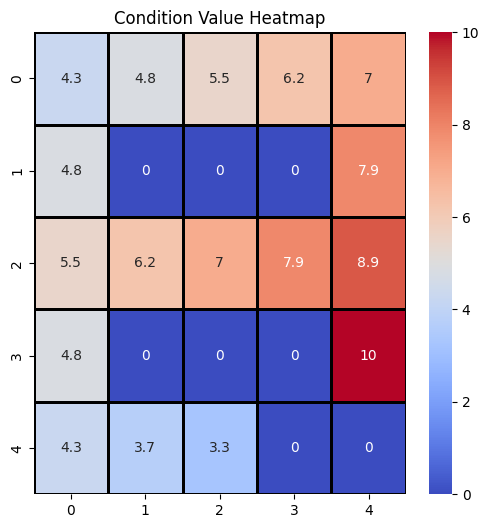

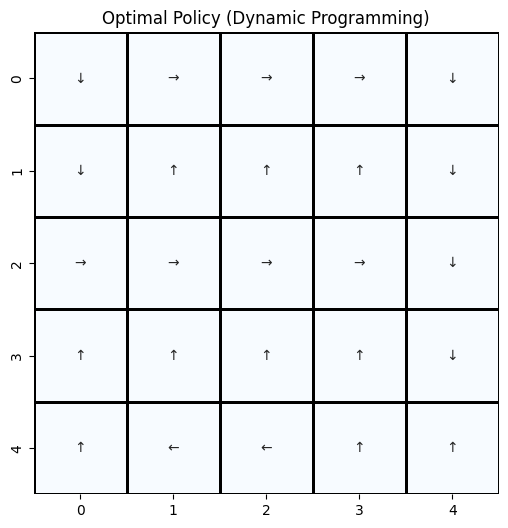

In [6]:
# 動的計画法の可視化
def plot_value_function(value_table):
  plt.figure(figsize=(6, 6))
  sns.heatmap(value_table, annot=True, cmap='coolwarm', cbar=True, linewidths=1, linecolor='black')
  plt.title("Condition Value Heatmap")
  plt.show()

def plot_policy_arrows(policy):
  plt.figure(figsize=(6, 6))
  arrows = {0: "↑", 1:"↓", 2:"←", 3:"→"}
  policy_grid = np.array([[arrows[a] for a in row] for row in policy])
  sns.heatmap(np.zeros_like(policy, dtype=float), annot=policy_grid, fmt="", cmap="Blues", cbar=False, linewidths=1, linecolor='black')
  plt.title("Optimal Policy (Dynamic Programming)")
  plt.show()

plot_value_function(value_table)
plot_policy_arrows(policy)

In [7]:
# Q学習の実装
def q_learning(env, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=500):
  q_table = np.zeros((*env.grid_size, 4))

  for episode in range(episodes):
    state = env.start
    while state != env.goal:
      if random.uniform(0, 1) < epsilon:
        action = random.choice(range(4))
      else:
        action = np.argmax(q_table[state])

      next_state, reward = env.step(state, action)
      best_next_action = np.argmax(q_table[next_state])
      q_table[state][action] += alpha * (reward + gamma * q_table[next_state][best_next_action] - q_table[state][action])
      state = next_state

  policy = np.argmax(q_table, axis=2)
  return q_table, policy

In [8]:
# Q学習の実行
q_table, q_policy = q_learning(env)
print("Q table:")
print(q_table)
print("Optimal Policy :")
print(q_policy)

Q table:
[[[ 3.19439149e+00 -1.94564176e-01  2.29684199e+00  4.26126590e+00]
  [ 2.90782166e+00  2.81713151e+00  2.07727084e+00  4.84585100e+00]
  [ 3.78210312e+00  3.29508627e+00  3.46065565e+00  5.49539000e+00]
  [ 4.33412017e+00  4.26039561e+00  2.69208775e+00  6.21710000e+00]
  [ 4.64123392e+00  7.01900000e+00  3.81543425e+00  3.91138334e+00]]

 [[-2.28811471e-01  1.43367493e-01 -2.13427288e-01 -2.14321859e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 4.50085920e+00  7.91000000e+00  4.79860036e+00  5.72944462e+00]]

 [[-1.64055523e-01 -1.65107978e-01 -1.57056807e-01  9.92984869e-01]
  [-1.12062554e-01 -1.05335266e-01 -9.19688804e-03  2.44002674e+00]
  [-6.76555517e-02  5.93291740e-01  5.63798092e-03  4.98653145e+00]
  [ 6.57263638e-01  3.80714520e-01  1.30520648e-01  7.74885084e+00]
  [ 5.59331269e+00  8.90000000e+00 

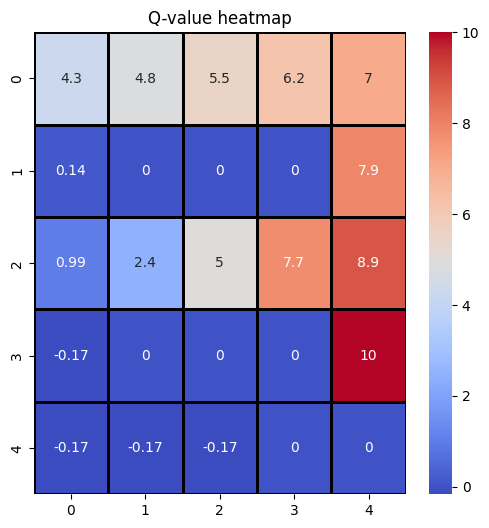

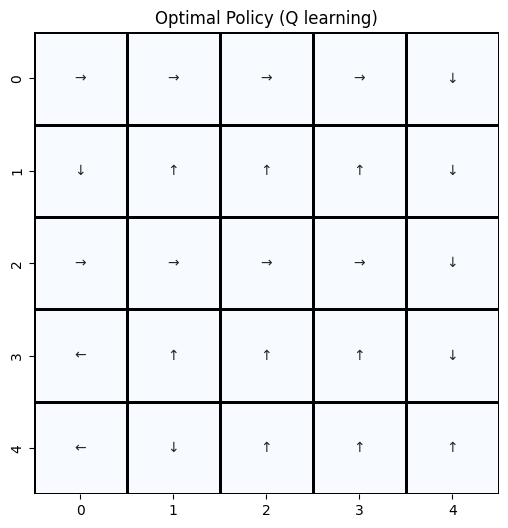

In [9]:
# Q値の可視化
def plot_q_values(q_table):
  max_q_values = np.max(q_table, axis=2)
  plt.figure(figsize=(6, 6))
  sns.heatmap(max_q_values, annot=True, cmap='coolwarm', cbar=True, linewidths=1, linecolor='black')
  plt.title("Q-value heatmap")
  plt.show()

def plot_q_policy(policy):
  plt.figure(figsize=(6, 6))
  arrows = {0: "↑", 1: "↓", 2: "←", 3: "→"}
  policy_grid = np.array([[arrows[a] for a in row] for row in policy])
  sns.heatmap(np.zeros_like(policy, dtype=float), annot=policy_grid, fmt="", cmap="Blues", cbar=False, linewidths=1, linecolor='black')
  plt.title("Optimal Policy (Q learning)")
  plt.show()

plot_q_values(q_table)
plot_q_policy(q_policy)